### To do
- faire une PCA

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, r2_score
from sklearn.metrics import auc, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer

### Loading the data

In [2]:
raw = pd.read_excel('data/dataframe_elections.xlsx')
print('Taille initiale du DF :', raw.shape)
raw_temp = raw.copy()
# Données d'identification
id_list = ['an', 'dep', 'circo', 'code', 'nom', 'prenom', 'nuance_groupe', 'taux_vote_leg', 'second_tour']
df_id = raw[id_list]

# drop colonnes
drop_list = ['dep', 'circo', 'c_dep', 'code', 'inscrits', 'circo_parti', 'circo_nuance',
             'nom', 'prenom', 'etiquette', 'nuance', 'voix', 'second_tour']
raw = raw.drop(drop_list, axis=1)

print('Taille du DF après retrait des colonnes inutiles :', raw.shape)

Taille initiale du DF : (36919, 79)
Taille du DF après retrait des colonnes inutiles : (36919, 66)


In [3]:
def generate_df(raw_data, keep_list):
    # à garder obligatoirement pour identifier les lignes et créer les labels
    keep_list.extend(['an', 'nuance_groupe', 'p_inscrits', 'p_exprimes'])

    df = raw_data.drop([col for col in raw_data.columns if col not in keep_list], axis=1)
    #print(df.columns)

    # Gestion des NaN au niveau du score du candidat aux législatives précédentes
    years = [2002, 2007, 2012, 2017]

    # TODO : POUR LES CANDIDATS "EN MARCHE", PAR QUOI REMPLIR LE SCORE DES CANDIDATS A LA PREC LEG ?
    if 'score_candidat_prec_leg' in keep_list:
        partis = ['EXG', 'COM', 'FI', 'DVG', 'ECO', 'SOC', 'RDG', 'MDM',
                  'UDI', 'DVD', 'LR', 'DLF', 'FN', 'EXD', 'REG', 'DIV']
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_inscrits'][mask_2]) # moyenne des voix du parti 5 ans avant
                df.loc[mask, 'score_candidat_prec_leg'] = df['score_candidat_prec_leg'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_inscrits)
        #print('\nRemplissage des dernières valeurs manquantes pour la législative précédente avec {:.2f}%'.format(mean * 100))
        df.score_candidat_prec_leg = df.score_candidat_prec_leg.fillna(value=mean)

    # Gestion des NaN : Autres variables. Remplacement des valeurs manquantes par la moyenne nationale
    features_a_completer = ['chom_tot']
    for feature in features_a_completer:
        if feature in keep_list:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(feature))
            for year in years:
                mask = (df['an']==year)
                mean = np.mean(df[feature][mask])
                #print('La moyenne de la feature pour {} est {:.2f}%'.format(year, mean * 100))
                df.loc[mask, feature] = df[feature][mask].fillna(value=mean)

    # Normaliser les votes


    # Catégorisation
    # df['score_candidat_prec_leg'] = pd.cut(df['score_candidat_prec_leg'], bins=[-1, -.01, .05, .1, .15, .2, 1],
    #                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])

    df = df[df.an > 1997]
    df = df[df.nuance_groupe!='DIV'] # On retire les candidats "Divers" (pour l'entraînement ET la prédiction)
    
    print('Format du dataframe :', df.shape)
    #print(df.isnull().sum())
    
    return df

In [4]:
def train_val_splits(df, year_for_validation, target, scaler=MinMaxScaler()):
    # Liste des variables dummies et binaires pour les exclure de la normalisation
    dummies_list = ['bloc', 'sexe', 'an', 'p_inscrits', 'p_exprimes', 'dep', 'circo',
                    'geo_frontalier', 'geo_dom', 'geo_idf',
                    'circo_nuance_groupe', 'circo_bloc', 'nuance_groupe',
                    'circo_nuance_groupe_pres', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
                    'circo_leg_meme_nuance',
                    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
                    'nb_candidats_meme_bloc', 'score_candidat_prec_leg']
    scale_list = [col for col in df.columns if col not in dummies_list]

    print('Variables à normaliser', scale_list)
    df = pd.get_dummies(df, drop_first=True)
    
    drop_list = ['an', 'p_inscrits', 'p_exprimes']
    df_train = df[(df.an != 2017) & (df.an != year_for_validation)].dropna(how='any')
    y_train = df_train[target]
    X_train = df_train.drop(drop_list, axis=1)
    
    df_val = df[df.an == year_for_validation].dropna(how='any')
    y_val = df_val[target]
    X_val = df_val.drop(drop_list, axis=1)
    
    # Normalisation du dataframe
    X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
    X_val[scale_list] = scaler.transform(X_val[scale_list])

    print(X_train.shape, X_val.shape)
    print(y_train.shape, y_val.shape)
    
    return X_train, X_val, y_train, y_val

In [5]:
def get_classif(y_pred, y_val, id_val, target):
    from scipy.stats import rankdata
    
    res = pd.concat([id_val, pd.DataFrame(y_val)], axis=1, join='inner')
    res['prediction'] = y_pred
    res['ecart'] = y_pred - res[target]
    res['classement'] = 0
    res['qualif'] = 'N'
    
    for circo in set(res.code):
        # classement des candidats par circonscription
        res.loc[res.code==circo, 'classement'] = rankdata(-res.prediction[res.code==circo], method='ordinal')
        
        # normalisation des votes pour que la somme soit égale à 100%
        res.loc[res.code==circo, 'prediction'] /= np.sum(res.loc[res.code==circo, 'prediction'])
        
        if target=='p_exprimes':
            taux_E = 1
            taux_O = np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
        elif target=='p_inscrits':
            taux_E = 1 / np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
            taux_O = 1
            
        # simulation des qualifiés pour le second tour
        i = 1
        q = 0
        while True:
            #print(res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values)
            if (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_E >= .5:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'E'
                break
            elif (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_O >= .125:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            elif q < 2:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            else:
                break

            i += 1
    return res

In [6]:
def analyze_predictions(df_predictions, target):
    n = df_predictions.shape[0]
    print('Prédictions pour {} candidats.'.format(n))

    ecarts_absolus = abs(df_predictions.ecart)
    max_ecart = np.max(ecarts_absolus)
    grid = np.arange(max_ecart, step=.01)
    ecarts_grid = []

    for point in grid:
        ecarts_grid.append(np.sum(ecarts_absolus < point))

    print('La MAE est : {:.2f}%'.format(
            mean_absolute_error(df_predictions[target], df_predictions.prediction) * 100))
    print('La plus grosse erreur est : {:.2f}%'.format(max_ecart * 100))
    print('Le score AUC est : {:.2f}%'.format(auc(grid, ecarts_grid) * 100 / n))
    print('Le score r2 est : {:.2f}'.format(r2_score(df_predictions[target], df_predictions.prediction)))

    point_list = [.01, .02, .05, .1]
    ecart_list = [np.sum(ecarts_absolus < point) for point in point_list]

    plt.figure(1, figsize=(17, 3))
    plt.subplot(131)
    plt.plot(grid, ecarts_grid)
    for i in range(len(point_list)):
        plt.plot(point_list[i], ecart_list[i], 'ro')
        plt.text(point_list[i]+.005, ecart_list[i]-400, '{:.2f}%'.format(ecart_list[i]/n))

    plt.title('Nb d\'obs en dessous d\'un seuil d\'erreur')
    plt.xlabel('Seuils d\'erreur')

    plt.subplot(132)
    plt.hist(df_predictions['ecart'], bins=50)
    plt.title('Répartition globale des erreurs')

    # comparaison de la distribution des erreurs, parti par parti
    from scipy.stats import gaussian_kde
    plt.subplot(133)
    x_grid = np.arange(min(df_predictions['ecart']), max(df_predictions['ecart']), step=.01)

    nuances = {'FI': 'red','ECO': 'green', 'SOC': 'pink', 'MDM': 'orange', 'UDI': 'yellow',
               'LR': 'blue', 'DLF': 'darkblue', 'FN': 'black', 'REG': 'teal'}
    for nuance in nuances:
        n_pred = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['qualif']=='E')
                               | (df_predictions['qualif']=='O'))].shape[0]
        n_reel = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['second_tour']=='E')
                               | (df_predictions['second_tour']=='O'))].shape[0]
        print('{}: {} prédits | Réel {}'.format(nuance, n_pred, n_reel))
        try: # cas où le parti n'est pas représenté à l'élection prédite
            pdf = gaussian_kde(df_predictions['ecart'][df_predictions['nuance_groupe']==nuance],
                               bw_method=.9).evaluate(x_grid)
            plt.plot(x_grid, pdf, color=nuances[nuance], label=nuance, lw=2)
        except:
            pass

    plt.title('Répartition des erreurs selon le parti')
    plt.legend(loc='best')

    n_correct = np.sum(df_predictions.second_tour == df_predictions.qualif)
    print('\n{} prédictions correctes sur {} (soit {:.1f}%)'.format(n_correct, n, 100 * n_correct / n))

    print('\nMatrice de confusion. En colonne les classes prédites, en ligne les classes réelles.')
    cm = confusion_matrix(df_predictions.second_tour, df_predictions.qualif, labels=['E', 'O', 'N'])
    print(cm)

    f1_E = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='E', average='micro')
    print('Score F1 pour la classe E : {:.1f}%'.format(f1_E * 100))
    f1_O = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='O', average='micro')
    print('Score F1 pour la classe O : {:.1f}%'.format(f1_O * 100))
    f1_N = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='N', average='micro')
    print('Score F1 pour la classe N : {:.1f}%'.format(f1_N * 100))
    plt.show()
    
    return

### Choix des paramètres

In [7]:
# Sélection des features
keep_list = [#'geo_frontalier', 'geo_dom', 'geo_idf',
    'part_impose', 'chom_tot',
    #'p_agri',
    'p_ouvriers',
    #'d_brevet',
    'd_sup',
    'circo_leg_meme_nuance', 'circo_meme_nuance_president', 'circo_pres_meme_nuance',
    'nb_candidats_meme_bloc',
    'score_nuance_groupe_pres',
    'score_candidat_prec_leg',
    #'score_nuance_groupe_prec_leg', #(un peu mauvais)
    #'score_bloc_pres', 'score_bloc_prec_leg', #(mauvais pour le score)
    'nuance_groupe',
    #'taux_vote_pres', 'taux_vote_leg',
    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre',
    'membre_majorite',
    'sexe'
]

scaler = MinMaxScaler()
#scaler = StandardScaler()
target_values = 'p_exprimes' # 'p_inscrits'
target_year = 2012

In [8]:
df = generate_df(raw, keep_list)
X_train, X_val, y_train, y_val = train_val_splits(df, target_year, target_values, scaler)

Format du dataframe : (26396, 20)
Variables à normaliser ['part_impose', 'chom_tot', 'p_ouvriers', 'd_sup', 'score_nuance_groupe_pres']
(13689, 31) (6024, 31)
(13689,) (6024,)


In [9]:
X_train.head(2)

,part_impose,chom_tot,p_ouvriers,d_sup,circo_leg_meme_nuance,nb_candidats_meme_bloc,circo_pres_meme_nuance,circo_meme_nuance_president,score_nuance_groupe_pres,score_candidat_prec_leg,...,nuance_groupe_EXG,nuance_groupe_FI,nuance_groupe_FN,nuance_groupe_LR,nuance_groupe_MDM,nuance_groupe_RDG,nuance_groupe_REG,nuance_groupe_REM,nuance_groupe_SOC,nuance_groupe_UDI
14488,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.018692,0.036679,...,0,0,0,0,0,0,0,0,0,0
14489,0.546669,0.061475,0.598684,0.331373,1.0,2.0,1.0,0.0,0.481142,0.223836,...,0,0,0,1,0,0,0,0,0,0


### Choix de modèle

In [ ]:
clf = RandomForestRegressor(criterion="mae")

param_grid = {'n_estimators': [5, 10],
             'max_depth' : [50, 75],
              "min_samples_leaf" : [1, 2],
              "min_samples_split" : [2,5, 10]
             }

rs = RandomizedSearchCV(clf, param_grid, cv=3, n_jobs=1, scoring=make_scorer(mean_absolute_error))
rs.fit(X_train, y_train)
#sorted(list(zip(rf.feature_importances_*100, X_train.columns)), reverse=True)

In [ ]:
rs.best_estimator_

In [ ]:
clf = rs.best_estimator_
clf.fit(X_train, y_train)
mean_absolute_error(clf.predict(X_val), y_val)

In [79]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(fit_intercept=True)

clf.fit(X_train, y_train)
mean_absolute_error(clf.predict(X_val), y_val)

0.037177162119964156

** XGBoost **

In [41]:
from xgboost import XGBRegressor

clf = XGBRegressor()
clf.fit(X_train, y_train)
mean_absolute_error(clf.predict(X_val), y_val)


0.032954943190532854

In [121]:
XGBRegressor()

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [21]:
import xgboost as xgb

T_train_xgb = xgb.DMatrix(X_train, y_train)

params = {"eval_metric":"mae"}
gbm = xgb.train(dtrain=T_train_xgb, params=params)
mean_absolute_error(gbm.predict(xgb.DMatrix(X_val)), y_val)


0.038940582928120852

In [38]:

clf = XGBRegressor()
param_grid = {'n_estimators': [75, 100, 125], #140, 150, 160: 160
              'max_depth' : [2, 3, 4, 5, 6, 7], #70
              "learning_rate" : [0.01, 0.1, 0.2, 0.3, 0.4], #0.05, 0.1, 0.2 : 0.05
              'min_child_weight' : [1], #4,5,6 :4
              'reg_alpha' : [0.5, 0.75, 1, 1.25, 1.5], #8, 10, 12 : 8
              'reg_lambda' : [0, 0.25, 0.5, 0.75, 1] #.7
             }

rs = RandomizedSearchCV(clf, param_grid, cv=3, n_jobs=-1, scoring=make_scorer(mean_absolute_error))
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'min_child_weight': [1], 'n_estimators': [75, 100, 125], 'max_depth': [2, 3, 4, 5, 6, 7], 'reg_lambda': [0, 0.25, 0.5, 0.75, 1], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4], 'reg_alpha': [0.5, 0.75, 1, 1.25, 1.5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(mean_absolute_error), verbose=0)

In [39]:
 rs.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=1.5, reg_lambda=0.75,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [40]:
clf = rs.best_estimator_
clf.fit(X_train, y_train)
mean_absolute_error(clf.predict(X_val), y_val)

0.14951703428282523

Prédictions pour 6024 candidats.
La MAE est : 3.41%
La plus grosse erreur est : 52.89%
Le score AUC est : 48.78%
Le score r2 est : 0.78
REG: 1 prédits | Réel 4
DLF: 1 prédits | Réel 1
ECO: 3 prédits | Réel 44
UDI: 29 prédits | Réel 45
LR: 455 prédits | Réel 422
SOC: 459 prédits | Réel 427
FI: 18 prédits | Réel 12
FN: 16 prédits | Réel 59
MDM: 9 prédits | Réel 12

5582 prédictions correctes sur 6024 (soit 92.7%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  15   21    0]
 [ 102  773  204]
 [   2  113 4794]]
Score F1 pour la classe E : 19.4%
Score F1 pour la classe O : 77.8%
Score F1 pour la classe N : 96.8%


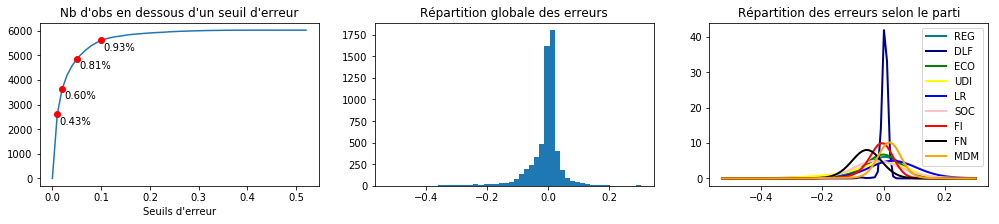

In [125]:
df_predictions = get_classif(clf.predict(X_val), y_val, df_id, target_values)
analyze_predictions(df_predictions, target_values)

** SGD Regressor **

In [99]:
from sklearn.linear_model import SGDRegressor

clf = SGDRegressor()

param_grid = {"loss" : ['squared_loss', "huber", "epsilon_insensitive", 'squared_epsilon_insensitive'],
              "penalty" : ["none", "l2", "l1", "elasticnet"],
              "l1_ratio" : [0.10, 0.5, 0.80] 
             }
rs = RandomizedSearchCV(clf, param_grid, cv=3, n_jobs=-1, scoring=make_scorer(mean_absolute_error))
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'l1_ratio': [0.1, 0.5, 0.8], 'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['none', 'l2', 'l1', 'elasticnet']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(mean_absolute_error), verbose=0)

In [100]:
clf = rs.best_estimator_
clf.fit(X_train, y_train)
mean_absolute_error(clf.predict(X_val), y_val)

0.077267572602871717

** MLP **

In [10]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor((100,100), activation='relu', solver='adam', alpha=0.001, batch_size=500,
                   learning_rate='adaptive', learning_rate_init=0.01, max_iter=100, tol=1e-7, verbose=True,
                  power_t=.5, early_stopping=False)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)

Iteration 1, loss = 0.08123648
Iteration 2, loss = 0.00188499
Iteration 3, loss = 0.00135954
Iteration 4, loss = 0.00125926
Iteration 5, loss = 0.00121035
Iteration 6, loss = 0.00120027
Iteration 7, loss = 0.00116649
Iteration 8, loss = 0.00115658
Iteration 9, loss = 0.00113285
Iteration 10, loss = 0.00114249
Iteration 11, loss = 0.00111257
Iteration 12, loss = 0.00110370
Iteration 13, loss = 0.00108537
Iteration 14, loss = 0.00109434
Iteration 15, loss = 0.00108558
Iteration 16, loss = 0.00106071
Iteration 17, loss = 0.00107455
Iteration 18, loss = 0.00106294
Iteration 19, loss = 0.00107466
Training loss did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


Prédictions pour 6024 candidats.
La MAE est : 3.95%
La plus grosse erreur est : 49.71%
Le score AUC est : 45.12%
Le score r2 est : 0.76
REG: 1 prédits | Réel 4
DLF: 1 prédits | Réel 1
ECO: 7 prédits | Réel 44
UDI: 29 prédits | Réel 45
LR: 467 prédits | Réel 422
SOC: 440 prédits | Réel 427
FI: 21 prédits | Réel 12
FN: 5 prédits | Réel 59
MDM: 14 prédits | Réel 12

5589 prédictions correctes sur 6024 (soit 92.8%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  15   21    0]
 [  90  786  203]
 [   1  120 4788]]
Score F1 pour la classe E : 21.1%
Score F1 pour la classe O : 78.4%
Score F1 pour la classe N : 96.7%


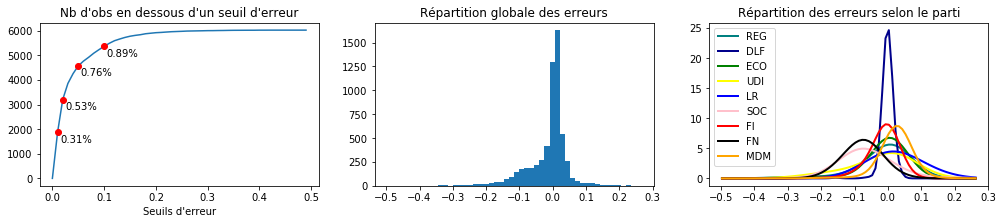

In [11]:
df_predictions = get_classif(y_pred, y_val, df_id, target_values)
analyze_predictions(df_predictions, target_values)

In [12]:
df_predictions.sort_values(by='ecart').head(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
10982,2012,LA-REUNION,2,974|2,BELLO,HUGUETTE,DVG,0.4562,E,0.6712,0.181734,-0.497085,2,O
9857,2012,GUADELOUPE,2,971|2,LOUIS-CARABIN,GABRIELLE,DVG,0.2982,O,0.5698,0.175176,-0.417073,3,N
12340,2012,PARIS,6,75|6,DUFLOT,CECILE,ECO,0.5929,O,0.4874,0.114992,-0.398639,2,O


In [13]:
df_predictions.sort_values(by='ecart').tail(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
11564,2012,MARTINIQUE,2,972|2,LEBON,FRANTZ,SOC,0.3253,N,0.0218,0.299730,0.233252,2,O
10518,2012,HERAULT,3,34|3,GRAND,JEAN-PIERRE,LR,0.6206,O,0.1734,0.385869,0.255573,1,O
12030,2012,NORD,10,59|10,VANNESTE,CHRISTIAN,DVD,0.4669,N,0.1311,0.330211,0.264594,1,O


#### Save predictions

In [14]:
from datetime import datetime
now = datetime.now()
stamp = '{}_{}_{}h{}'.format(now.day, now.month, now.hour, now.minute)
df_predictions.to_excel('predictions_du_{}.xlsx'.format(stamp))

In [43]:
df_tour_2 = pd.read_csv("ETL Legislative 2T/data/dataset_legislative_2nd.csv", encoding="latin1")

In [44]:
df_tour_2.columns

Index(['an', 'Code département', 'département', 'circonscription', 'code',
       'name', 'first_name', 'sexe', 'circo_bloc', 'circo_leg_meme_nuance',
       'circo_pres_meme_nuance', 'score_bloc_pres', 'depute_sortant',
       'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'bloc', 'p_voix',
       'voix_y', 'Inscrits', 'score', 'elu', 'top_triangulaire',
       'bloc_opposant_Centre', 'bloc_opposant_Divers', 'bloc_opposant_Droite',
       'bloc_opposant_Exdroite', 'bloc_opposant_Exgauche',
       'bloc_opposant_Gauche', 'voix_bloc_1nd', 'p_voix_2nd_lag',
       'p_voix_candidat_2nd_lag'],
      dtype='object')

In [45]:
X_train

,part_impose,chom_tot,p_ouvriers,d_sup,circo_leg_meme_nuance,nb_candidats_meme_bloc,circo_pres_meme_nuance,circo_meme_nuance_president,score_nuance_groupe_pres,score_candidat_prec_leg,...,nuance_groupe_EXG,nuance_groupe_FI,nuance_groupe_FN,nuance_groupe_LR,nuance_groupe_MDM,nuance_groupe_RDG,nuance_groupe_REG,nuance_groupe_REM,nuance_groupe_SOC,nuance_groupe_UDI
14488,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.018692,0.036679,...,0,0,0,0,0,0,0,0,0,0
14489,0.546669,0.061475,0.598684,0.331373,1.0,2.0,1.0,0.0,0.481142,0.223836,...,0,0,0,1,0,0,0,0,0,0
14490,0.546669,0.061475,0.598684,0.331373,0.0,1.0,0.0,0.0,0.157710,0.070266,...,0,0,1,0,0,0,0,0,0,0
14491,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.326268,0.184033,...,0,0,0,0,0,0,0,0,1,0
14492,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.043224,0.014068,...,0,0,0,0,0,0,0,0,0,0
14493,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.043224,0.007800,...,0,0,0,0,0,0,0,0,0,0
14494,0.546669,0.061475,0.598684,0.331373,0.0,2.0,0.0,0.0,0.037884,0.024475,...,0,0,0,0,0,0,0,0,0,0
14495,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.071262,0.008900,...,1,0,0,0,0,0,0,0,0,0
14497,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.071262,0.005100,...,1,0,0,0,0,0,0,0,0,0
14498,0.546669,0.061475,0.598684,0.331373,0.0,1.0,0.0,0.0,0.280040,0.089691,...,0,0,0,0,1,0,0,0,0,0


In [42]:
clf.predict(X_train)

array([ 0.0390552 ,  0.45842269,  0.03808892, ...,  0.08586746,
        0.02320811,  0.04097056], dtype=float32)

In [56]:
df_tour_2 = df_tour_2.merge(df_predictions[["code", "nom", "prenom", "prediction", "pred_bloc"]], how='left', right_on=["code", "nom", "prenom"], left_on=["code", "name", "first_name"], copy=False)

In [57]:
df_tour_2.head()

,an,Code département,département,circonscription,code,name,first_name,sexe,circo_bloc,circo_leg_meme_nuance,...,bloc_opposant_Exdroite,bloc_opposant_Exgauche,bloc_opposant_Gauche,voix_bloc_1nd,p_voix_2nd_lag,p_voix_candidat_2nd_lag,nom,prenom,prediction,pred_bloc
0,2012,1,AIN,1.0,1|1,BRETON,XAVIER,M,Droite,1.0,...,0,0,1,0.2306,0.536621,0.536621,BRETON,XAVIER,0.449346,0.484800
1,2012,1,AIN,1.0,1|1,DEBAT,JEAN-FRANCOIS,M,Droite,0.0,...,0,0,0,0.2492,0.463379,0.463379,DEBAT,JEAN-FRANCOIS,0.311764,0.361462
2,2012,1,AIN,2.0,1|2,DE LA VERPILLIERE,CHARLES,M,Droite,1.0,...,1,0,1,0.2209,NaN,NaN,DE LA VERPILLIERE,CHARLES,0.643471,0.643471
3,2012,1,AIN,2.0,1|2,EYRAUD,OLIVIER,M,Droite,0.0,...,0,0,1,0.1252,NaN,NaN,EYRAUD,OLIVIER,0.093810,0.093810
4,2012,1,AIN,2.0,1|2,RAYMOND,MICHEL,M,Droite,0.0,...,1,0,0,0.2024,NaN,NaN,RAYMOND,MICHEL,0.049042,0.120963


In [83]:
df_tour_2["bloc_second_tour?_lag"] = df_tour_2["p_voix_2nd_lag"].map(lambda x : 0 if np.isnan(x) else 1)
df_tour_2["candidat_second_tour?_lag"] = df_tour_2["p_voix_candidat_2nd_lag"].map(lambda x : 0 if np.isnan(x) else 1)

df_tour_2.drop(["nom", "prenom", "p_voix_2nd_lag", "p_voix_candidat_2nd_lag"], axis=1, inplace=True)


In [89]:
df_tour_2.merge(df_tour_2.groupby('code')["score"].max().reset_index(), how="left")

,an,Code département,département,circonscription,code,name,first_name,sexe,circo_bloc,circo_leg_meme_nuance,...,bloc_opposant_Divers,bloc_opposant_Droite,bloc_opposant_Exdroite,bloc_opposant_Exgauche,bloc_opposant_Gauche,voix_bloc_1nd,prediction,pred_bloc,bloc_second_tour?_lag,candidat_second_tour?_lag
0,2012,1,AIN,1.0,1|1,BRETON,XAVIER,M,Droite,1.0,...,0,0,0,0,1,0.2306,0.449346,0.484800,1,1
1,2012,1,AIN,1.0,1|1,DEBAT,JEAN-FRANCOIS,M,Droite,0.0,...,0,1,0,0,0,0.2492,0.311764,0.361462,1,1
2,2012,1,AIN,2.0,1|2,DE LA VERPILLIERE,CHARLES,M,Droite,1.0,...,0,0,1,0,1,0.2209,0.643471,0.643471,0,0
3,2012,1,AIN,2.0,1|2,EYRAUD,OLIVIER,M,Droite,0.0,...,0,1,0,0,1,0.1252,0.093810,0.093810,0,0
4,2012,1,AIN,2.0,1|2,RAYMOND,MICHEL,M,Droite,0.0,...,0,1,1,0,0,0.2024,0.049042,0.120963,0,0
5,2012,1,AIN,3.0,1|3,BLANC,ETIENNE,M,Droite,1.0,...,0,0,0,0,1,0.2297,0.509098,0.504041,1,1
6,2012,1,AIN,3.0,1|3,FOGNINI,JEAN-MARC,M,Droite,0.0,...,0,1,0,0,0,0.2055,0.315196,0.369086,1,0
7,2012,1,AIN,4.0,1|4,LACROIX,GUILLAUME,M,Droite,0.0,...,0,1,0,0,0,0.2038,0.173257,0.236791,0,0
8,2012,1,AIN,4.0,1|4,VOISIN,MICHEL,M,Droite,1.0,...,0,0,0,0,1,0.2445,0.600751,0.598127,0,0
9,2012,1,AIN,4.0,1|4,VOISIN,MICHEL,M,Droite,1.0,...,0,0,0,0,1,0.2445,0.600751,0.600751,0,0


In [82]:
pd.get_dummies(df_tour_2, columns=['circonscription', 'sexe', 'circo_bloc', "bloc"], drop_first=True)

,an,Code département,département,code,name,first_name,circo_leg_meme_nuance,circo_pres_meme_nuance,score_bloc_pres,depute_sortant,...,circo_bloc_Divers,circo_bloc_Droite,circo_bloc_Exdroite,circo_bloc_Exgauche,circo_bloc_Gauche,bloc_Divers,bloc_Droite,bloc_Exdroite,bloc_Exgauche,bloc_Gauche
0,2012,1,AIN,1|1,BRETON,XAVIER,1.0,1.0,0.2570,1.0,...,0,1,0,0,0,0,1,0,0,0
1,2012,1,AIN,1|1,DEBAT,JEAN-FRANCOIS,0.0,0.0,0.2147,0.0,...,0,1,0,0,0,0,0,0,0,1
2,2012,1,AIN,1|2,DE LA VERPILLIERE,CHARLES,1.0,1.0,0.2753,1.0,...,0,1,0,0,0,0,1,0,0,0
3,2012,1,AIN,1|2,EYRAUD,OLIVIER,0.0,0.0,0.1798,0.0,...,0,1,0,0,0,0,0,1,0,0
4,2012,1,AIN,1|2,RAYMOND,MICHEL,0.0,0.0,0.2027,0.0,...,0,1,0,0,0,0,0,0,0,1
5,2012,1,AIN,1|3,BLANC,ETIENNE,1.0,1.0,0.2671,1.0,...,0,1,0,0,0,0,1,0,0,0
6,2012,1,AIN,1|3,FOGNINI,JEAN-MARC,0.0,0.0,0.2090,0.0,...,0,1,0,0,0,0,0,0,0,1
7,2012,1,AIN,1|4,LACROIX,GUILLAUME,0.0,0.0,0.1944,0.0,...,0,1,0,0,0,0,0,0,0,1
8,2012,1,AIN,1|4,VOISIN,MICHEL,1.0,1.0,0.2876,1.0,...,0,1,0,0,0,0,1,0,0,0
9,2012,1,AIN,1|4,VOISIN,MICHEL,1.0,1.0,0.2876,1.0,...,0,1,0,0,0,0,1,0,0,0
